# **Module 2 Demonstration - Text Corpora Sources \& Basic Text Statistics**

## Name: Dallin Moore

## *DATA 5420/64250*

In this demonstration we will begin by loading in some precompiled corpora from various sources and compare them using basic text statistics and visualization. Then we will scrape five website's 'About Us' pages, perform some basic cleaning and normalization the text from each of the scraped webpages, and then finally display some basic text statistics which we will append onto the dataframe and display in a frequency distribution plot.

In a second demonstration we will run through requesting data via API.

Before we can get started you will need to perform a pip install for the following libraries (unless you've previously installed them). See below:

### Pip Installs --
#### Open the terminal and install the following dependencies:

* pip install webdriver-manager
* pip install selenium
* pip install nltk
* pip install beautifulsoup4

In [ ]:
!pip3 install webdriver-manager
!pip3 install selenium
!pip3 install nltk
!pip3 install beautifulsoup4
!pip3 install matplotlib
!pip3 install sklearn
!pip3 install seaborn
!pip3 install --upgrade webdriver_manager

### Load in libaries

I'm assuming usage of `Selenium` with Google Chrome, if you want to use a different browser, see documentation [here](https://github.com/SergeyPirogov/webdriver_manager).

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import re
from string import punctuation

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Download the Brown corpus
nltk.download('brown')

from nltk.corpus import brown


from sklearn.datasets import fetch_20newsgroups
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import re

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\04drm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\04drm\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


## Loading in a Precompiled Corpus...some examples...

The `nltk` library has a number of common corpora you can download and then load into python, as does `sklearn`. Let's try that out real quick below...

In [10]:
# BROWN CORPUS
# Add comments
fileids = brown.fileids()

# establish empty lists
texts = []
categories = []

for fileid in fileids:
    words = brown.words(fileid)
    text = ' '.join(words)
    texts.append(text)

    category = brown.categories(fileid)
    categories.append(category[0])  # take the fist categor for each file

    
brown_df = pd.DataFrame({
    'Description': texts,
    'genre': categories
})

brown_df['Source'] = 'Brown'
brown_df.head()

,Description,genre,Source
0,The Fulton County Grand Jury said Friday an in...,news,Brown
1,"Austin , Texas -- Committee approval of Gov. P...",news,Brown
2,Several defendants in the Summerdale police bu...,news,Brown
3,Oslo The most positive element to emerge from ...,news,Brown
4,East Providence should organize its civil defe...,news,Brown


In [11]:
brown_df['genre'].value_counts()

learned            80
belles_lettres     75
lore               48
news               44
hobbies            36
government         30
fiction            29
adventure          29
romance            29
editorial          27
mystery            24
reviews            17
religion           17
humor               9
science_fiction     6
Name: genre, dtype: int64

**Examine the brown corpus and list out what type of texts we're dealing with based on the categories:**

There is a wide range, but there are is not an even distribution of sources for each category.

In [12]:
# Fetch the 20 newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all')

# acces the data and the target
data = newsgroups.data
target = newsgroups.target
target_names = newsgroups.target_names

# map the two together
target_labels = [target_names[i] for i in target]

# Create the DataFrame
newsgroups_df = pd.DataFrame({
    'Description': data,
    'genre': target_labels
})

newsgroups_df['Source'] = 'News20'
newsgroups_df.head()

,Description,genre,Source
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,rec.sport.hockey,News20
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,comp.sys.ibm.pc.hardware,News20
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,talk.politics.mideast,News20
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,comp.sys.ibm.pc.hardware,News20
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,comp.sys.mac.hardware,News20


In [14]:
newsgroups_df['genre'].value_counts()

rec.sport.hockey            999
soc.religion.christian      997
rec.motorcycles             996
rec.sport.baseball          994
sci.crypt                   991
rec.autos                   990
sci.med                     990
comp.windows.x              988
sci.space                   987
comp.os.ms-windows.misc     985
sci.electronics             984
comp.sys.ibm.pc.hardware    982
misc.forsale                975
comp.graphics               973
comp.sys.mac.hardware       963
talk.politics.mideast       940
talk.politics.guns          910
alt.atheism                 799
talk.politics.misc          775
talk.religion.misc          628
Name: genre, dtype: int64

**Similarly, examine the genres of the News20 corpus and state some of the main categories within the corpus:**

There are different levels of genres, with a high level genres, sub genres, and sub-sub so we could decide how far to break it down.

**Now let's head over to [Kaggle](https://www.kaggle.com/datasets?tags=13204-NLP) and find a dataset to download!**

I chose this [IMDB dataset](https://www.kaggle.com/datasets/ishikajohari/imdb-data-with-descriptions?resource=download) since it's in a csv file already, so easy to download and access. But explore some on your own and see if there's any datasets that interest you!

In [18]:
IMDB_df = pd.read_csv("C:/Users/04drm/Downloads/IMDB.csv")
IMDB_df['genre'] = IMDB_df['genres'].str.split(',').str[0]
IMDB_df = IMDB_df[['Description', 'genre']] # drop out extra columns
IMDB_df['Source'] = 'IMDB'
IMDB_df.head()

,Description,genre,Source
0,"Jodie Foster stars as Clarice Starling, a top ...",Crime,IMDB
1,"In this sequel set eleven years after ""The Ter...",Action,IMDB
2,This Disney animated feature follows the adven...,Adventure,IMDB
3,Vincent Vega (John Travolta) and Jules Winnfie...,Crime,IMDB
4,Andy Dufresne (Tim Robbins) is sentenced to tw...,Drama,IMDB


## Some basic Text Statistics and Plots

Let's get some basic insights into these datasets using some descriptive statistics and visualizations -- think of this as doing exploratory analysis!

We'll begin by combining our various datasets so we can compare them:

In [21]:
all_text = pd.concat([brown_df, newsgroups_df, IMDB_df])
all_text

,Description,genre,Source
0,The Fulton County Grand Jury said Friday an in...,news,Brown
1,"Austin , Texas -- Committee approval of Gov. P...",news,Brown
2,Several defendants in the Summerdale police bu...,news,Brown
3,Oslo The most positive element to emerge from ...,news,Brown
4,East Providence should organize its civil defe...,news,Brown
...,...,...,...
7845,Two men begin a romantic relationship in Bueno...,Drama,IMDB
7846,Nova Scotia's trailer parks are colorful thank...,Animation,IMDB
7847,"Two retired women, Nina and Madeleine, have be...",Drama,IMDB
7848,A 30-something Argentine poet on vacation in B...,Drama,IMDB


In [22]:
# count words
all_text['word_count'] = all_text['Description'].apply(lambda x: len(str(x).split()))

# count sentences
all_text['sentence_count'] = all_text['Description'].apply(lambda x: str(x).count('.') + str(x).count('!') + str(x).count('?'))

# average word length
all_text['avg_word_length'] = all_text['Description'].apply(lambda x: sum(len(word) for word in str(x).split()) / len(str(x).split()) if len(str(x).split()) > 0 else 0)

all_text.head()

,Description,genre,Source,word_count,sentence_count,avg_word_length
0,The Fulton County Grand Jury said Friday an in...,news,Brown,2242,115,4.573595
1,"Austin , Texas -- Committee approval of Gov. P...",news,Brown,2277,143,4.505490
2,Several defendants in the Summerdale police bu...,news,Brown,2275,114,4.480879
3,Oslo The most positive element to emerge from ...,news,Brown,2217,84,4.832206
4,East Providence should organize its civil defe...,news,Brown,2244,121,4.437611


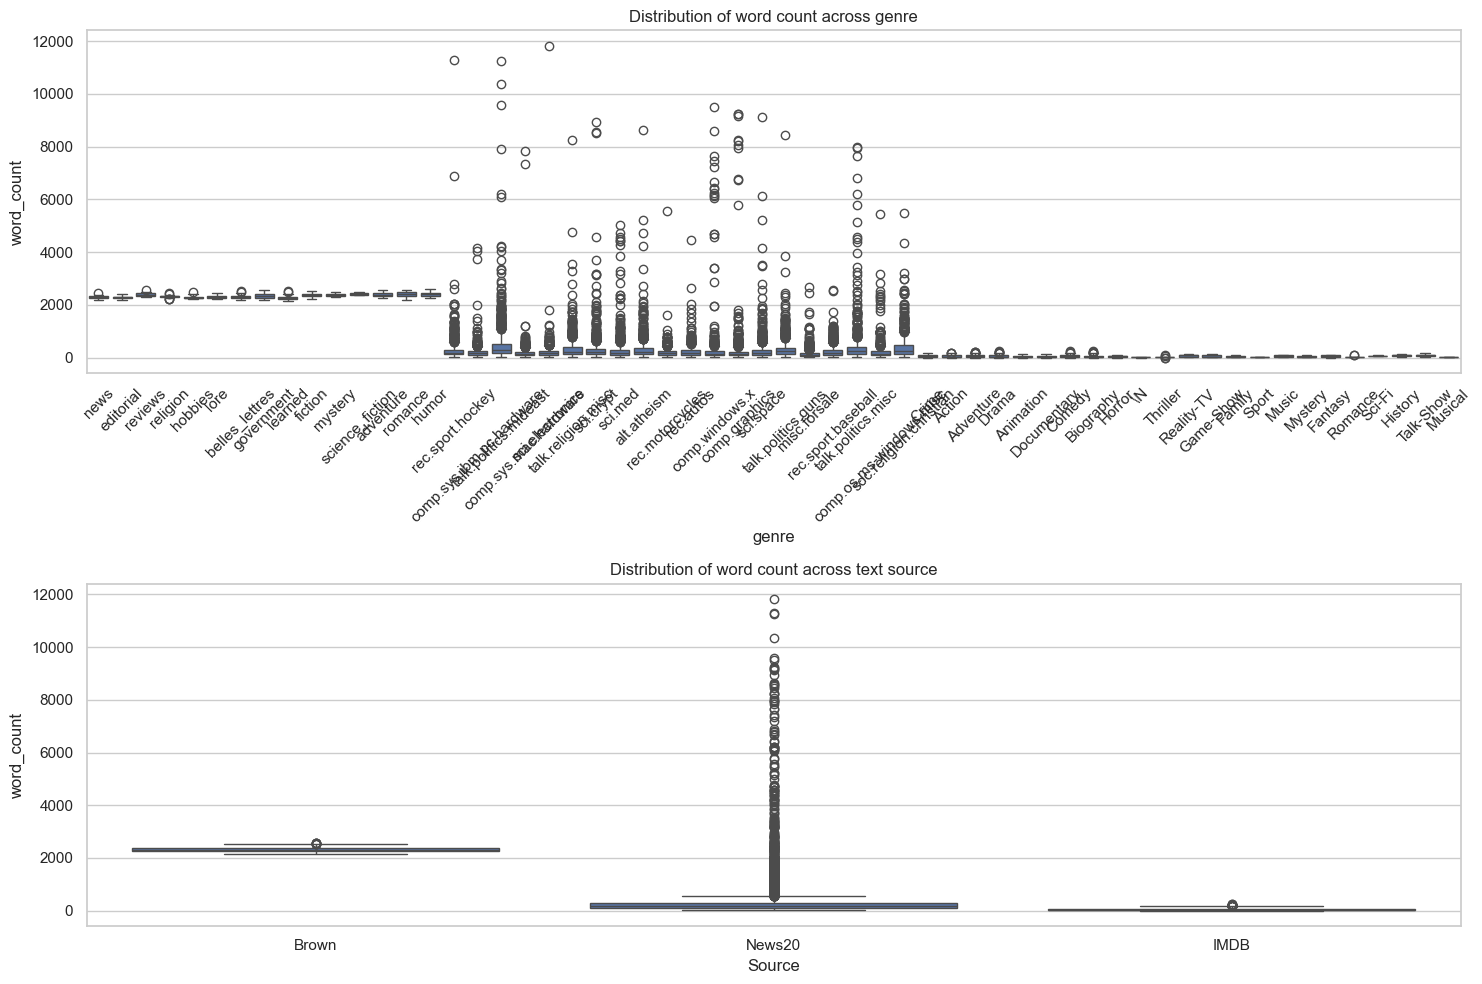

In [23]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# plot the distribution of the word count across genre
plt.subplot(2, 1, 1)
sns.boxplot(x='genre', y='word_count', data=all_text)
plt.title('Distribution of word count across genre')
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.boxplot(x='Source', y='word_count', data=all_text)
plt.title('Distribution of word count across text source')

plt.tight_layout()
plt.show()

**Use the plots and text statistics to comment on any interesting patterns that differentiate the sources or genres:**

Each of the sources have a fairly standardized word count where the plots are really tight. Although every genre within the news source has many outliers. These massive outliers actually make the other sources harder to interpret because they do not have outliers to the extent of the news source. Looking at the average word count, the Brown corpus is by far the greatest without any instance that are even close to the averages found in the other corpuses. IMDB is the tightest distribution and the lowest average word count. 

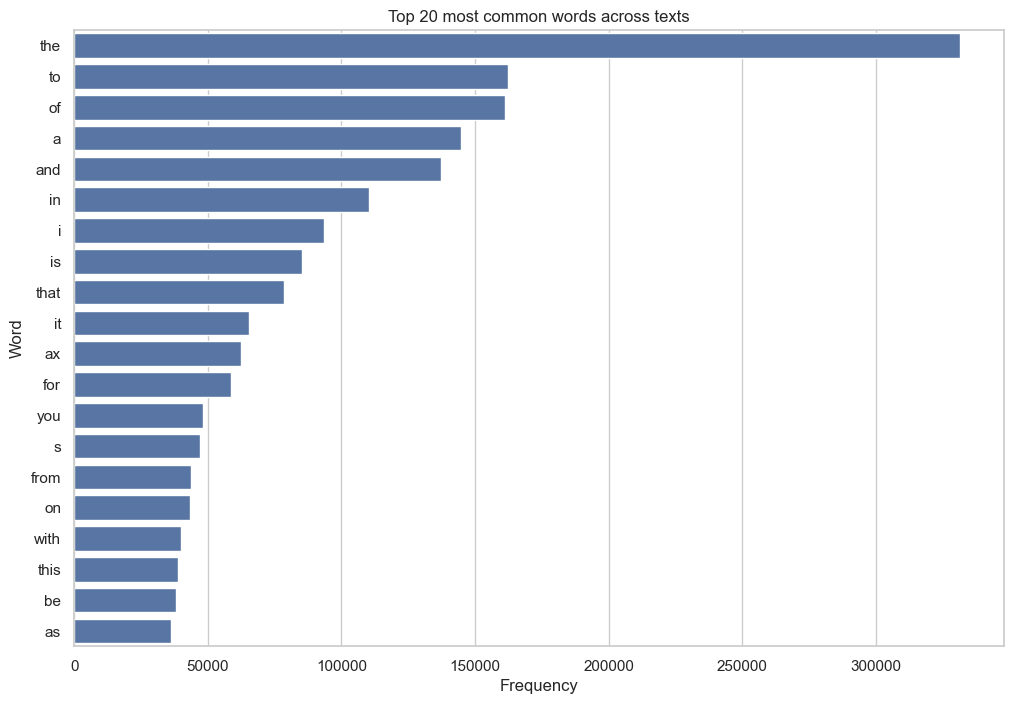

In [25]:
# Concatenating all the descriptions into a single string
all_texts_str = " ".join(all_text['Description'].astype(str))

# Using regex and lowercasing to tokenize the string into words
words = re.findall(r'\b\w+\b', all_texts_str.lower())

# Counting the frequency of each word
word_counts = Counter(words)

# Finding the 20 most common words
most_common_words = word_counts.most_common(20)

# Creating a DataFrame for plotting
df_most_common_words = pd.DataFrame(most_common_words, columns=['Word','Frequency'])

# Plotting the frequency distribution of the top 20 most common words
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=df_most_common_words)
plt.title('Top 20 most common words across texts')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


**What do we notice about the top 20 most frequent words?**

They are almost all words without meaning that link the rest of the words in a sentence. Except for 'ax' and 's.' I imagine 's' is probably from in error in splitting it into it's own word when it is preceded by a colon. However, 'ax' seems very strange given the dataset. I think that some meaning could be derived from 'ax' showing up, but it's hard to say what.

### Create Scraper Function using Selenium

In [50]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

def scrape_about_us_pages(about_us_urls):
    #driver = webdriver.Chrome(ChromeDriverManager().install())
    
    # for me, the above driver did not work, but this is what I have done before when web scraping with selenium+chrome
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(options=options)
    
    about_us_pages = {}

    for url in about_us_urls:
        driver.get(url)

        current_url = driver.current_url
        about_us_content = driver.find_element('tag name','body').text

        about_us_pages[current_url] = about_us_content

    driver.quit()

    df = pd.DataFrame.from_dict(about_us_pages, orient = 'index',columns = ['About Us Content'])
    df.index.name = "URL"

    return df

### Create a List of the Website Pages to be Scraped, Write to a DataFrame

In [51]:
about_us_urls = [
    "https://www.ecdcom.com/index.jsp?path=aboutus",
    "https://www.btx.com/about-us",
    "https://www.almo.com/About",
    "https://www.blackbox.com/en-us/discover-bb/about-blackbox",
    "https://www.wesco.com/us/en/our-company/history.html"

]

scraped_df = scrape_about_us_pages(about_us_urls)

In [52]:
scraped_df.head()

,About Us Content
URL,
https://www.ecdcom.com/index.jsp?path=aboutus,713-525-3206 (Call / Text) or 800-392-5156 (To...
https://www.btx.com/about-us,"Free shipping on all orders over $1,500 shippe..."
https://www.almo.com/About,Company\nLogin\nPro AV/Electronics\nHospitalit...
https://www.blackbox.com/en-us/discover-bb/about-blackbox,Investors Careers Support Contact Us\nLogin\n\...
https://www.wesco.com/us/en/our-company/history.html,Products\nSolutions\nIndustries\nServices\nBra...


### Create Clean_Text Function then Apply to 'About Us Content' column in Df

In [59]:
import nltk
nltk.download('punkt')

def clean_text(text):
    cleaned_text = BeautifulSoup(text, 'html.parser').get_text()


    cleaned_text = re.sub(r'[^a-zA-Z0-9\s\.]', '', cleaned_text)
    cleaned_text = cleaned_text.lower() # lowercase
    cleaned_text = cleaned_text.strip() # remove extra whitespaces

    stop_words = set(stopwords.words("english")) # bring in stopwords
    tokens = word_tokenize(cleaned_text) # tokenize
    cleaned_tokens = [token for token in tokens if token not in stop_words] # remove stopwords

    cleaned_text = ' '.join(cleaned_tokens) #rejoin tokens

    return cleaned_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\04drm\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [60]:
scraped_df['Cleaned About Us Content'] = scraped_df['About Us Content'].apply(clean_text)

In [61]:
print(scraped_df['Cleaned About Us Content'][0])

7135253206 call text 8003925156 tollfree go forgot loginpassword dealer become one us brands monthly specials career opportunities contact us product categories brands featured products new product lines audio pro av video control lighting network security surveillance bulk wire interconnect fiber optic installation hardware accessories mounts racks power surge structured panels clearance electronic custom distributors originally known electronic component distributors locally owned locally operated wholesale electronic hardware distributor texas . established june 1960 third generation family operations selling designing home av home office network security proav control solutions including sound video walls . texas best place us business serve houston location austin location dallas location san antonio location investments website soe software makes ecd experience advanced intuitive experience searching ordering product needs . choose delivery options pickup curbside drivethrough 24

### Produce Basic Text Statistic Metrics --
Total Number of Words, Total Number of Unique Words, Lexical Diversity, \& Average Word Length

In [62]:
def calculate_word_metrics(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.lower() not in punctuation]

    total_words = len(tokens)
    unique_words = len(set(tokens))
    lexical_div = unique_words/len(tokens)
    avg_word_length = sum(len(word) for word in tokens)/len(tokens)

    return total_words, unique_words, lexical_div, avg_word_length

In [65]:
scraped_df[["Total Words", "Unique Words", "Lexical Diversity", "Avg Word Length"]] = scraped_df['Cleaned About Us Content'].apply(calculate_word_metrics).apply(pd.Series)

scraped_df.head()

,About Us Content,Cleaned About Us Content,Total Words,Unique Words,Lexical Diversity,Avg Word Length
URL,,,,,,
https://www.ecdcom.com/index.jsp?path=aboutus,713-525-3206 (Call / Text) or 800-392-5156 (To...,7135253206 call text 8003925156 tollfree go fo...,323.0,218.0,0.674923,6.467492
https://www.btx.com/about-us,"Free shipping on all orders over $1,500 shippe...",free shipping orders 1500 shipped within conti...,335.0,238.0,0.710448,6.928358
https://www.almo.com/About,Company\nLogin\nPro AV/Electronics\nHospitalit...,company login pro avelectronics hospitality ma...,1108.0,582.0,0.525271,7.208484
https://www.blackbox.com/en-us/discover-bb/about-blackbox,Investors Careers Support Contact Us\nLogin\n\...,investors careers support contact us login 0 d...,156.0,104.0,0.666667,6.967949
https://www.wesco.com/us/en/our-company/history.html,Products\nSolutions\nIndustries\nServices\nBra...,products solutions industries services brands ...,970.0,557.0,0.574227,7.052577


**Does it make more sense to report on basic text statistics before or after removing stopwords? (There isn't a right or wrong answer, just explain your thinking).**

Definitely after removing stopwords. The stopwords showed up as the most common words but after there would be more insightful words that show up.

### Create Frequency Distribution Plots to Display Top N words per Page

In [66]:
def generate_freq_dist(text, n=10):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.lower() not in punctuation]
    fdist = FreqDist(tokens)
    top_words = fdist.most_common(n)

    plt.figure(figsize=(7,3))
    fdist.plot(n, cumulative=False)
    plt.show()

Website: https://www.ecdcom.com/index.jsp?path=aboutus


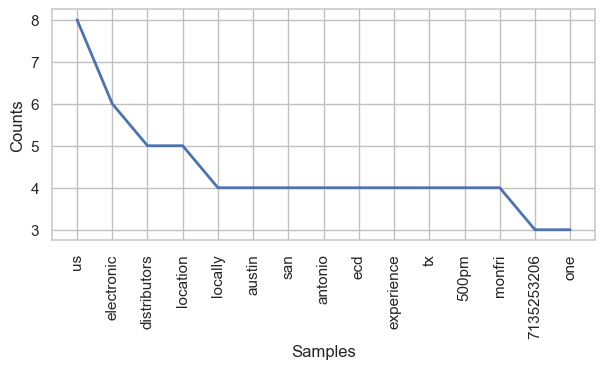

-------------------------------------------------------------------------

Website: https://www.btx.com/about-us


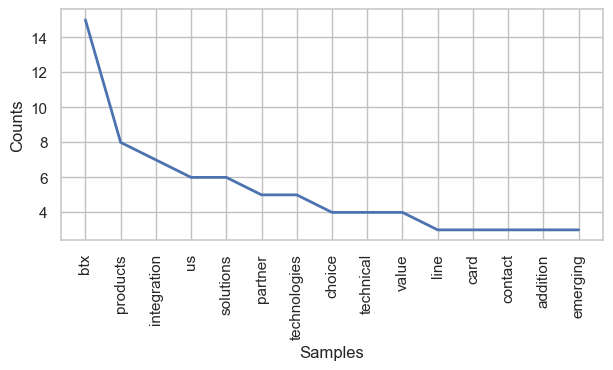

-------------------------------------------------------------------------

Website: https://www.almo.com/About


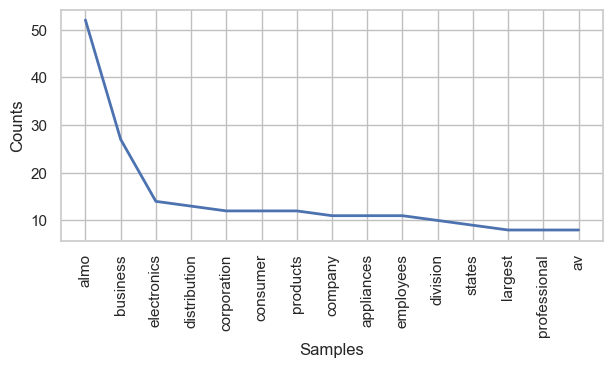

-------------------------------------------------------------------------

Website: https://www.blackbox.com/en-us/discover-bb/about-blackbox


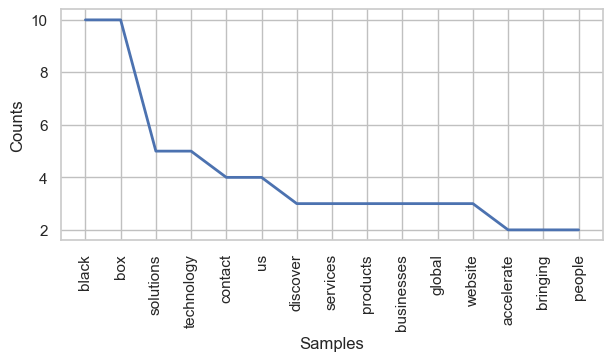

-------------------------------------------------------------------------

Website: https://www.wesco.com/us/en/our-company/history.html


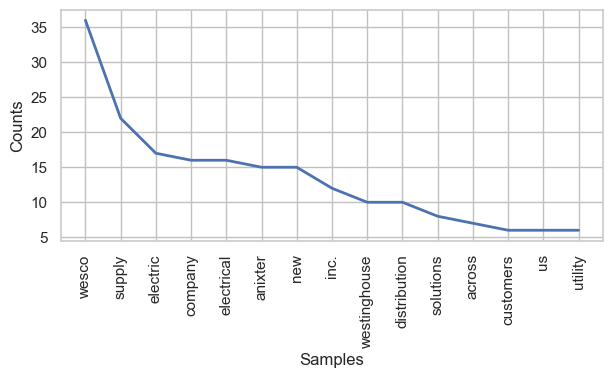

-------------------------------------------------------------------------



In [68]:
for index, row in scraped_df.iterrows():
    print("Website:", index)
    generate_freq_dist(row['Cleaned About Us Content'], n=15)
    print("-------------------------------------------------------------------------\n")

**What do we gain by removing stopwords from the text before running things like a frequency distribution?**

We can see meaningful insights about what words where used most. For instance, for a couple of these the website name is the top word used, and then keywords that indicate what industry they are in. Without dropping the stopwords we wouldn't see anything as interesting in the top results.

**What are some basic pieces of information we can get from our corpora by examining basic text statistis and visualizations?**

For the about us pages, we can see what seems to be important to each company. We can make a good guess what their industry is and what differentiates each companies from eachother.